$$
\begin{gathered}
d \nu_t=\kappa\left(\theta-\nu_t\right) d t+\sigma \sqrt{\nu_t} d W_t^\nu \\
d S_t=\mu S_t d t+\sqrt{\nu_t} S_t d W_t^S
\end{gathered}
$$

In [4]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('datasets\merged_test.csv')
df = df.dropna(subset=['stockPrice'])
df['Datetime'] = pd.to_datetime(df['Datetime']).dt.tz_localize(None)
df['Expiration_Date'] = pd.to_datetime(df['Expiration_Date'])
df['Time_to_Expiration'] = (
    df['Expiration_Date'] - df['Datetime']) / pd.Timedelta(days=365)
df = df[df['CALL_PUT'] == 'CALL']
df = df[df['contractSymbol'] == 'SPY231117C00455000']

In [11]:
# heston model 
def heston_option_price(s0, K, T, v0, θ, κ, σ, μ, option_type='call',n_simulations=10):
    """
        s0 (_type_): stockPrice
        K (_type_): Strike
        T (_type_): Time_to_Expiration
        v0 (_type_): the initial variance
        θ (_type_): the long variance, or long-run average variance of the price; as t tends to infinity, the expected value of νt tends to θ
        κ (_type_): the mean-reversion rate of the variance; as t tends to infinity, the expected value of νt tends to θ
        σ (_type_): the volatility of the variance
        μ (_type_): risk-free rate
        option_type (str, optional):Defaults to 'call'.
        
        
    """
    # Parameters
    n_steps = 1_000
    dt = T / n_steps
    #n_simulations = 10

    # Generate correlated Wiener processes
    dw1 = np.random.normal(0, np.sqrt(dt), (n_simulations, n_steps))
    dw2 = μ * dw1 + np.sqrt(1 - μ**2) * np.random.normal(0, np.sqrt(dt), (n_simulations, n_steps))
    
    # Initialize arrays
    v = np.zeros((n_simulations, n_steps + 1))
    v[:, 0] = v0
    s = np.zeros_like(v)
    s[:, 0] = s0
    # Simulate the Heston process
    for t in range(n_steps):
        v[:, t+1] = v[:, t] + κ * (θ - v[:, t]) * dt + σ * v[:, t]**0.5 * dw2[:, t]
        s[:, t+1] = s[:, t] + μ*s[:, t] * dt + v[:, t]**0.5 * s[:, t] * dw1[:, t]
        #formula by https://en.wikipedia.org/wiki/Heston_model#Basic_Heston_model
        
        #v[:, i+1] = np.maximum(v[:, i+1],0)
        #s[:, i+1] = s[:, i] + s[:, i] * np.exp((r - 0.5 * v[:, i]) * dt + np.sqrt(v[:, i]) * dw1[:, i])

    if option_type == 'call':
        option_payoff = np.maximum(s[:, -1] - K, 0)
        # price = np.mean(s[:, -1])
    else:
        option_payoff = np.maximum(K - s[:, -1], 0)
    
    option_price = np.mean(option_payoff) * np.exp(-μ * T)

    return option_price

In [5]:
df = pd.read_csv('datasets\merged_test.csv')
df = df.dropna(subset=['stockPrice'])
df['Datetime'] = pd.to_datetime(df['Datetime']).dt.tz_localize(None)
df['Expiration_Date'] = pd.to_datetime(df['Expiration_Date'])
df['Time_to_Expiration'] = (
    df['Expiration_Date'] - df['Datetime']) / pd.Timedelta(days=365)
df = df[df['CALL_PUT'] == 'CALL']
df = df[df['contractSymbol'] == 'SPY231117C00455000']

df

,Datetime,Open,High,Low,Close,Volume,contractSymbol,Ticker,Expiration_Date,CALL_PUT,Strike,stockPrice,Time_to_Expiration
244140,2023-07-24 09:31:00,16.58,16.58,16.58,16.58,0.0,SPY231117C00455000,SPY,2023-11-17,CALL,455.0,454.079987,0.316722
244141,2023-07-24 09:42:00,16.79,16.79,16.79,16.79,7.0,SPY231117C00455000,SPY,2023-11-17,CALL,455.0,454.339905,0.316701
244142,2023-07-24 09:45:00,16.75,16.75,16.75,16.75,2.0,SPY231117C00455000,SPY,2023-11-17,CALL,455.0,454.260010,0.316695
244143,2023-07-24 09:50:00,16.32,16.32,16.32,16.32,4.0,SPY231117C00455000,SPY,2023-11-17,CALL,455.0,453.730011,0.316686
244144,2023-07-24 09:56:00,15.87,16.03,15.87,16.03,5.0,SPY231117C00455000,SPY,2023-11-17,CALL,455.0,452.959991,0.316674
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654279,2023-09-01 15:15:00,9.73,9.73,9.73,9.73,3.0,SPY231117C00455000,SPY,2023-11-17,CALL,455.0,450.690002,0.209218
1654280,2023-09-01 15:21:00,9.72,9.72,9.72,9.72,6.0,SPY231117C00455000,SPY,2023-11-17,CALL,455.0,450.670013,0.209207
1654281,2023-09-01 15:25:00,9.81,9.81,9.81,9.81,8.0,SPY231117C00455000,SPY,2023-11-17,CALL,455.0,450.850006,0.209199
1654282,2023-09-01 15:32:00,9.97,9.97,9.97,9.97,10.0,SPY231117C00455000,SPY,2023-11-17,CALL,455.0,451.154999,0.209186


In [12]:
option_price = heston_option_price(s0=400, K=450, T=1, v0=0.2, θ=0.1, κ=2, σ=0.3, μ=-0.5, option_type='call')
option_price

16.02061717140091

In [6]:
option_prices = []
for index, row in df.iterrows():
    S = row['stockPrice']
    K = row['Strike']
    T = row['Time_to_Expiration']
    μ = 0.03  # You can set the risk-free rate as needed
    v0 = 0.1   # You can set the initial volatility as needed       #0.025
    θ = 0.1  # long-term mean of the variance
    κ = 2.0  # mean-reversion rate
    σ = 0.3  # volatility of variance
    μ = -0.5   # correlation between the two Brownian motions
    option_type = row['CALL_PUT']
    
    option_price = heston_option_price(S, K, T, v0, θ, κ, σ, μ, option_type='call')
    option_prices.append(option_price)

df['Option_Price'] = option_prices

# Print the DataFrame with option prices
# 2hours runing code 
print(df['Option_Price'])

KeyboardInterrupt: 

In [ ]:
print(df)

                   Datetime  Open  High   Low  Close  Volume  \
206189  2023-07-24 09:30:00  9.47  9.47  9.47   9.47     0.0   
206190  2023-07-24 09:32:00  9.67  9.67  9.67   9.67    14.0   
206191  2023-07-24 09:34:00  9.69  9.69  9.69   9.69    18.0   
206192  2023-07-24 09:41:00  9.80  9.80  9.80   9.80     2.0   
206193  2023-07-24 09:42:00  9.80  9.80  9.80   9.80     7.0   
...                     ...   ...   ...   ...    ...     ...   
1538365 2023-09-01 15:55:00  1.88  1.88  1.88   1.88    75.0   
1538366 2023-09-01 15:56:00  1.89  1.89  1.89   1.89    14.0   
1538367 2023-09-01 15:57:00  1.91  1.91  1.89   1.89   558.0   
1538368 2023-09-01 15:58:00  1.89  1.89  1.89   1.89   457.0   
1538369 2023-09-01 15:59:00  1.89  1.89  1.83   1.83   204.0   

             contractSymbol Ticker Expiration_Date CALL_PUT  Strike  \
206189   SPY230915C00455000    SPY      2023-09-15     CALL   455.0   
206190   SPY230915C00455000    SPY      2023-09-15     CALL   455.0   
206191   SPY230915

In [17]:
print(df['Option_Price'])

206189     8.216361
206190     8.554409
206191     8.779850
206192     8.721142
206193     8.734677
             ...   
1538365    5.910600
1538366    5.659830
1538367    5.953726
1538368    6.190038
1538369    5.726127
Name: Option_Price, Length: 4687, dtype: float64


In [ ]:
new_df = pd.DataFrame({
    'Datetime': df['Datetime'],
    'Actual_Value': df['Close'],
    'Theoretical_Value': df['Option_Price']
})
new_df

,Datetime,Actual_Value,Theoretical_Value
206189,2023-07-24 09:30:00,9.47,8.216361
206190,2023-07-24 09:32:00,9.67,8.554409
206191,2023-07-24 09:34:00,9.69,8.779850
206192,2023-07-24 09:41:00,9.80,8.721142
206193,2023-07-24 09:42:00,9.80,8.734677
...,...,...,...
1538365,2023-09-01 15:55:00,1.88,5.910600
1538366,2023-09-01 15:56:00,1.89,5.659830
1538367,2023-09-01 15:57:00,1.89,5.953726
1538368,2023-09-01 15:58:00,1.89,6.190038


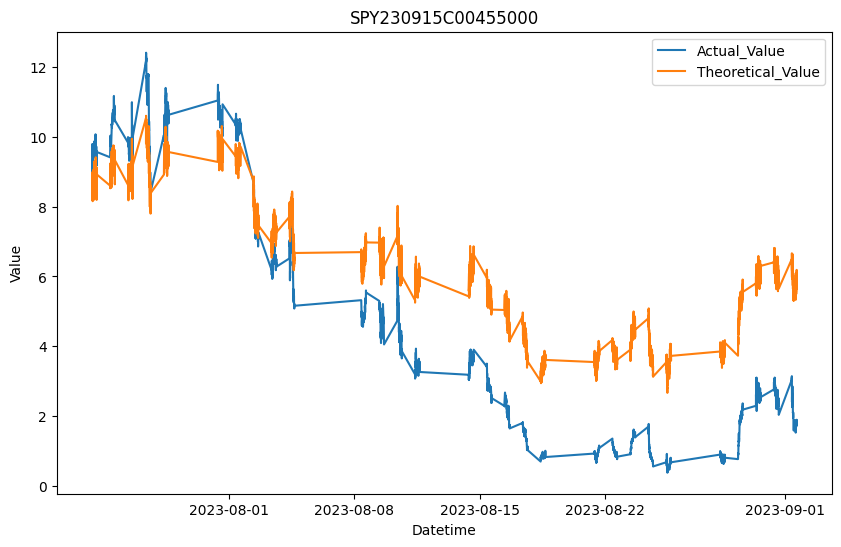

Cross Entropy: 1.0


In [ ]:

new_df
# 將Datetime欄位轉換為日期時間型態
new_df['Datetime'] = pd.to_datetime(new_df['Datetime'])
# 設定圖形的大小
plt.figure(figsize=(10, 6))
# 繪製Actual_Value線
plt.plot(new_df['Datetime'], new_df['Actual_Value'], label='Actual_Value')
# 繪製Theoretical_Value線
plt.plot(new_df['Datetime'], new_df['Theoretical_Value'], label='Theoretical_Value')
# 添加圖例
plt.legend()
# 添加標題和軸標籤 
plt.title('SPY230915C00455000')
plt.xlabel('Datetime')
plt.ylabel('Value')

# 顯示圖形
plt.show()

# 將實際值和理論值轉換成概率分佈
actual_prob = new_df['Actual_Value'] / new_df['Actual_Value'].sum()
theoretical_prob = new_df['Theoretical_Value'] / new_df['Theoretical_Value'].sum()

# 計算交叉熵
 
p=[1/10 for i in range(10)] # list comprehension
cross_entropy = -np.sum(p * np.log10(p))
print("Cross Entropy:", cross_entropy)